In [1]:
import os
import re
import numpy as np
from pprint import pprint

In [2]:
import pandas as pd
#To view all the rows and columns in a dataframe when printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
# absolute path to dataset (change to the path on ypur machine)
PATH_TO_DATASET = "D:\GP\Data\IEMOCAP_full_release\IEMOCAP_full_release"
PATH_TO_SAVE_TO = "D:\GP\Data\IEMOCAP_full_release\Data_Prep"
# relative pathes inside the data set 
WHOLE_VIDEO_PATH = r"\dialog\avi\DivX"
TRANSCRIPTION_PATH = r"\dialog\transcriptions"
ANNOTATION_PATH = r"\dialog\EmoEvaluation\Categorical"

___
### Two functions for parsing transcription and evaluation files and returning a dataframe

In [16]:
def parse_annotations_file(file_path:str)->pd.DataFrame:
    """
    A function that takes a path to an annotations file and returns a dataframe with the annotations

    Args:
        file_path (str): complete path to the annotations file

    Returns:
        pd.DataFrame: recording_name, emotion
    """
    recording_name = []
    emoj = []
    # Open the text file for reading
    with open(file_path, 'r') as file:
        # Read all lines from the file
        lines = file.readlines()

        # Process each line
        for line in lines:
            # Split the line into tokens based on some delimiter
            delimiters =r'[:;]'
            tokens = re.split(delimiters, line)
            recording_name.append(tokens[0].strip())
            local_list = []
            # Process each token [if the annotator cant decide on one emotion they will put some emotions]
            for token in tokens[1:]:
                token = token.strip()
                brackets = ["(",")"]
                contains_brackets = any(char in brackets for char in token)
                if token == "Other" or (contains_brackets and len(token)==2):
                    continue
                elif contains_brackets and len(token)>3:
                    local_list.append(token[1:-1])  # remove brackets
                elif len(token)!=0:
                    local_list.append(token)
                   
            emoj.append(local_list) 
    # create a dataframe with the annotations file results
    df=pd.DataFrame({'RecordingName': recording_name, 'Emotions_'+file_path.split("\\")[-1].split("_")[-2]: emoj})
    return df

In [17]:
#Test the above function
print(parse_annotations_file(r'D:\GP\Data\IEMOCAP_full_release\IEMOCAP_full_release\Session1\dialog\EmoEvaluation\Categorical\Ses01M_script03_2_e4_cat.txt'))

             RecordingName           Emotions_e4
0   Ses01M_script03_2_F000       [Neutral state]
1   Ses01M_script03_2_F001       [Neutral state]
2   Ses01M_script03_2_F002       [Neutral state]
3   Ses01M_script03_2_F003            [Surprise]
4   Ses01M_script03_2_F004       [Neutral state]
5   Ses01M_script03_2_F005       [Neutral state]
6   Ses01M_script03_2_F006       [Neutral state]
7   Ses01M_script03_2_F007       [Neutral state]
8   Ses01M_script03_2_F008       [Neutral state]
9   Ses01M_script03_2_F009       [Neutral state]
10  Ses01M_script03_2_F010       [Neutral state]
11  Ses01M_script03_2_F011             [annoyed]
12  Ses01M_script03_2_F012             [annoyed]
13  Ses01M_script03_2_F013             [annoyed]
14  Ses01M_script03_2_F014             [annoyed]
15  Ses01M_script03_2_F015             [annoyed]
16  Ses01M_script03_2_F016             [annoyed]
17  Ses01M_script03_2_F017       [Neutral state]
18  Ses01M_script03_2_F018             [annoyed]
19  Ses01M_script03_

In [18]:
def parse_transcription_file(file_path:str)->pd.DataFrame:
    """
    A function that takes a path to a transcription file and returns a dataframe with the transcription

    Args:
        file_path (str): complelete path to the transcription file

    Returns:
        pd.DataFrame: recording_name, transcription, start, end
    """
    transcriptions = []
    file_name = []
    start = []
    end = []
    # Open the text file for reading
    with open(file_path, 'r') as file:
        # Read all lines from the file
        lines = file.readlines()

        pattern = r'\[(\d+\.\d+)-(\d+\.\d+)\]'
        # Process each line
        for line in lines:
            tokens = line.split(':')
            if len(tokens[0]) < 6:
                continue
            transcriptions.append(tokens[-1].strip())
            # print(tokens[0])
            name, start_end = tokens[0].split()
            file_name.append(name.strip())
            # Search for the start and end time in the string
            matches = re.search(pattern, start_end)
            if matches:
                start.append(matches.group(1))
                end.append(matches.group(2))
    df = pd.DataFrame({'RecordingName': file_name, 'Transcription': transcriptions, 'Start': start, 'End': end})
    return df

In [19]:
#Test the above function
print(parse_transcription_file(r"D:\GP\Data\IEMOCAP_full_release\IEMOCAP_full_release\Session1\dialog\transcriptions\Ses01F_impro01.txt"))

          RecordingName                                      Transcription  \
0   Ses01F_impro01_F000                                         Excuse me.   
1   Ses01F_impro01_M000                            Do you have your forms?   
2   Ses01F_impro01_F001                                              Yeah.   
3   Ses01F_impro01_M001                                   Let me see them.   
4   Ses01F_impro01_F002                                Is there a problem?   
5   Ses01F_impro01_M002                  Who told you to get in this line?   
6   Ses01F_impro01_F003                                           You did.   
7   Ses01F_impro01_F004  You were standing at the beginning and you dir...   
8   Ses01F_impro01_M003  Okay. But I didn't tell you to get in this lin...   
9   Ses01F_impro01_F005        Well what's the problem?  Let me change it.   
10  Ses01F_impro01_M004                           This form is a Z.X.four.   
11  Ses01F_impro01_M005  You can't--  This is not the line for Z

___
### Generate csv files for all the sessions 

In [20]:
def determine_emotion(column1,column2,column3):
    def add_to_dictionary(dic, items_list):
        # Case where no emotion is written (rather than a list  it is nan)
        if type(items_list) == float:
            if "No emotion" in my_dictionary:
                my_dictionary["No emotion"] += 1
            else:
                my_dictionary["No emotion"] = 1
            return
        for item in items_list:
            item = item.strip().upper()
            if item in my_dictionary:
                dic[item] += 1/len(items_list)
            else:
                dic[item] = 1/len(items_list)
    final_emotion = []
    for item1, item2, item3 in zip(column1,column2,column3):
        my_dictionary = dict()
        add_to_dictionary(my_dictionary, item1)
        add_to_dictionary(my_dictionary, item2)
        add_to_dictionary(my_dictionary, item3)
        final_emotion.append(max(my_dictionary, key=lambda k: my_dictionary[k]))
    return final_emotion

In [ ]:
# loop on the sessions to get the transcription of each session and their coresponding annotations files
final_csv=[]
for i in range(1,6):
    #Prepare the directory to save in
    folder_path_to_save_in = PATH_TO_SAVE_TO+f"\Session{i}\\"
    # Check if the directory exists
    if not os.path.exists(folder_path_to_save_in):
        # Create the directory if it doesn't exist
        os.makedirs(folder_path_to_save_in)
        print(f"Directory '{folder_path_to_save_in}' created successfully.")
    else:
        print(f"Directory '{folder_path_to_save_in}' already exists.")
    
    dfs = []#to save the dataframes of the same session
    
    directory = PATH_TO_DATASET + f"\Session{i}"+TRANSCRIPTION_PATH
    files = os.listdir(directory)
    filtered_files = [file for file in files if not file.startswith('._')]
    txt_files = [file for file in filtered_files if file.endswith('.txt')]
    print(len(txt_files))
    
    for file in txt_files:
        print("Transcription: "+directory+"\\"+file)
        directory2 = PATH_TO_DATASET + f"\Session{i}"+ANNOTATION_PATH
        files2 = os.listdir(directory2)
        #get the annotations files for the current transcript file
        filtered_files2 = [file2 for file2 in files2 if (file2.startswith(file[:-4]) and file2[len(file)-4])=="_"]
        #get the .txt files
        txt_files2 = [file2 for file2 in filtered_files2 if file2.endswith('.txt')]
        print("\t",txt_files2)
        print(len(txt_files2))
        
        transcription_dataframe = parse_transcription_file(directory+"\\"+file)
        for file2 in txt_files2:
            annotations_dataframe = parse_annotations_file(directory2+"\\"+file2)
            transcription_dataframe = pd.merge(transcription_dataframe, annotations_dataframe, on='RecordingName' , how= 'outer')
        #Determine the final emotion of the clip
        columns_to_exclude = ["RecordingName", "Transcription", "Start", "End", "Emotion"]
        selected_columns = transcription_dataframe.loc[:, ~transcription_dataframe.columns.isin(columns_to_exclude)]
        selected_lists = [selected_columns[column].tolist() for column in selected_columns]
        print(selected_lists[0],"\n",selected_lists[1],"\n",selected_lists[2])
        
        transcription_dataframe["Emotion"]=determine_emotion(selected_lists[0],selected_lists[1],selected_lists[2])
        transcription_dataframe.to_csv(folder_path_to_save_in+file[:-4]+".csv", index=False)
        
        dfs.append(transcription_dataframe)
    
    #create a dataframe from all csv files in the folder and save it as one big csv file in the folder    
    combined_df = pd.concat(dfs, axis=0)
    columns_to_keep = ["RecordingName", "Transcription", "Start", "End", "Emotion"]
    combined_df = combined_df[columns_to_keep]
    final_csv.append(combined_df)
    combined_df.to_csv(folder_path_to_save_in+"combined.csv", index=False)
    print("\n\n")
    
final_dataframe = pd.concat(final_csv, axis=0)
final_dataframe.to_csv(PATH_TO_SAVE_TO+"\combined.csv", index=False)

___
___
Now that we have a csv with all the emotions we will drop entries where there is no emotion, see how the data is distributed among emotions and split them into train, test, val sets

In [4]:
import matplotlib.pyplot as plt

In [5]:
# get stats about the data (pie chart of emotions)
iemocap_df = pd.read_csv(PATH_TO_SAVE_TO+"\combined.csv" )

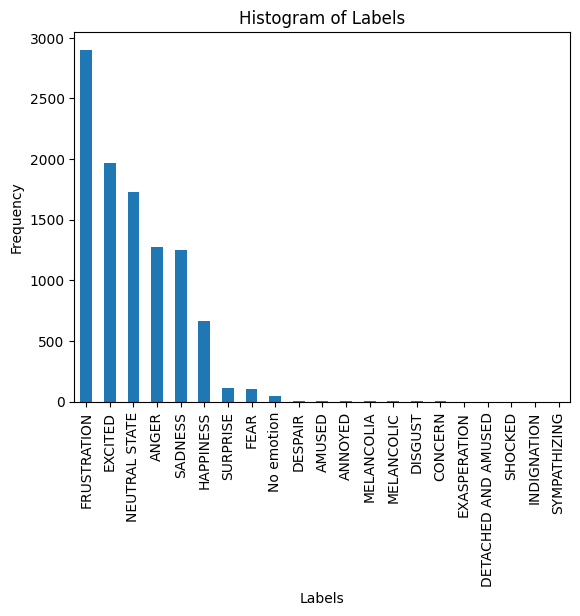

In [10]:
label_counts = iemocap_df['Emotion'].value_counts()
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Labels')
plt.show()

In [11]:
print(label_counts)

Emotion
FRUSTRATION            2902
EXCITED                1966
NEUTRAL STATE          1729
ANGER                  1277
SADNESS                1253
HAPPINESS               664
SURPRISE                112
FEAR                    106
No emotion               48
DESPAIR                   7
AMUSED                    6
ANNOYED                   4
MELANCOLIA                2
MELANCOLIC                2
DISGUST                   2
CONCERN                   2
EXASPERATION              1
DETACHED AND AMUSED       1
SHOCKED                   1
INDIGNATION               1
SYMPATHIZING              1
Name: count, dtype: int64


In [31]:
# Drop emotions with low counts
drop_emotions = label_counts[label_counts < 100].index.to_list()
print(drop_emotions)
# Drop rows where the 'Name' column has the values 'Alice' or 'David'
iemocap_filtered = iemocap_df[~iemocap_df['Emotion'].isin(drop_emotions)]
label_counts_filtered = iemocap_filtered['Emotion'].value_counts()
print(label_counts_filtered)
print(f"Length of the filtered datafame is {len(iemocap_filtered)}")

['No emotion', 'DESPAIR', 'AMUSED', 'ANNOYED', 'MELANCOLIA', 'MELANCOLIC', 'DISGUST', 'CONCERN', 'EXASPERATION', 'DETACHED AND AMUSED', 'SHOCKED', 'INDIGNATION', 'SYMPATHIZING']
Emotion
FRUSTRATION      2902
EXCITED          1966
NEUTRAL STATE    1729
ANGER            1277
SADNESS          1253
HAPPINESS         664
SURPRISE          112
FEAR              106
Name: count, dtype: int64
Length of the filtered datafame is 10009


In [32]:
from sklearn.model_selection import train_test_split

In [35]:
# Train Val Test  split
# Splitting data into 80% train(60% train, 20% validate) and 20% test 
train_data, test_data = train_test_split(iemocap_filtered, test_size=0.2, stratify=iemocap_filtered["Emotion"], random_state=42)

# Splitting the remaining 80% into 75% train and 25% validation (20% validation)
train_data, validation_data = train_test_split(train_data, test_size=0.25, stratify=train_data["Emotion"], random_state=42)

# Add a new column to each DataFrame indicating the attribute ('train', 'test', 'validate')
train_data['category'] = 'train'
test_data['category'] = 'test'
validation_data['category'] = 'validate'

# Concatenate the DataFrames together
combined_df = pd.concat([train_data, test_data, validation_data], ignore_index=True)

# Sort the combined DataFrame by 'Attribute' and 'id'
combined_df = combined_df.sort_values(by=['RecordingName'])

# Write the sorted DataFrame to a CSV file
try:
    combined_df.to_csv(PATH_TO_SAVE_TO+"\Annotations.csv", index=False)
    print("Successful split into train_data, test_data, validation_data")
except PermissionError as e:
    print("The csv file is opend please close the the file to allow overwrite.\n"+str(e))
except Exception as ex:
    # Handling any other exceptions that might occur
    print("An error occurred:", ex)
    

Successful split into train_data, test_data, validation_data
